### Goal

Flatten a Res1D object into a "simple" generic network representation that can be specified solely in terms of nodes and edges.

### Assumptions

- User provides a valid Res1D object and a quantity
- User is aware of potential confusing parts of the network, where they need to specify which element to select
- In urban networks, sensors are located close to the nodes
    - User will know the id of an edge and will pass it to specify that the network element that needs to be matched is sitting on that edge
    - Only the closest gridpoint that includes the relevant quantity is selected

### Implementation

- The script will return a generic network. Every node will have an ID and an associated timeseries (for later matching through modelskill)
- modelskill should only be aware of this generic network language
- mikeio1d should be able to transform a Res1D object into this generic network (as well as other formats in the future)
- Potential function signature:
```
    def flatten_network(res: Res1D, quantity: str, by: "node", prioritize={"edge":"100l1"}) -> QuantityNetwork
```



In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum

from mikeio1d import Res1D

res = Res1D("../tests/testdata/network.res1d")
res

<mikeio1d.Res1D>

In [2]:
class NetworkBackend(Enum):
    MIKE1D = 1
    EPANET = 2
    CUSTOM = 3


class QuantityNode:
    def __init__(self, id: str):
        self.id = id


class QuantityNetwork:
    def __init__(self, network: Res1D, quantity: str, backend=NetworkBackend.MIKE1D):
        self._quantity = quantity
        self.graph = self.extract_graph(network, backend)

    def extract_graph(self, net, backend: NetworkBackend) -> nx.Graph:
        if backend == NetworkBackend.MIKE1D:
            g = self._extract_from_mike1d(net)
            return g
        else:
            raise NotImplementedError("Currently, we only support MIKE1D as network backend.")
    
    def _extract_from_mike1d(self, net: Res1D):
        G = nx.Graph()
        for reach in net.reaches.values():
            if self.quantity in reach.quantities:
                G.add_edge(reach.start_node, reach.end_node, length=reach.length)
        return G

    @property
    def quantity(self) -> str:
        return self._quantity

    def closest_element(self) -> QuantityNode:
        raise NotImplementedError()       

In [3]:
from mikeio1d.result_network import ResultNode, ResultReach, ResultGridPoint, ResultCatchment
from typing import Dict, List

In [4]:
def flatten_network(res: Res1D, quantity: str, priority: Dict[str, List]):
    def overlapping_elements(node: ResultNode) -> List[ResultNode | ResultGridPoint]:
        gridpoints = []
        for reach in res.reaches.values():
            if reach.start_node == node_id:
                gridpoints.append(reach.gridpoints[0])
            elif reach.end_node == node_id:
                gridpoints.append(reach.gridpoints[-1])
        return [node] + gridpoints

    def filter_by_quantity(elements: List[ResultGridPoint | ResultNode]) -> List[ResultGridPoint | ResultNode]:
        return [element for element in elements if (element is not None) and (quantity in element.quantities)]   

    selected_elements = []
    for node_id, node in res.nodes.items():
        # TODO: refresh, can catchment be an overlapping element?
        elements = overlapping_elements(node)
        relevant_elements = filter_by_quantity(elements)
        if len(relevant_elements) == 0:
            # No elements were found with the relevant quantity
            pass
        elif len(relevant_elements) == 1:
            # Only one element was found, which is directly passed to the network
            element = relevant_elements[0]
            print(type(element))
        else:
            # Multiple elements were found, so we check priority
            priority_elements = []
            for element in relevant_elements:
                if isinstance(element, ResultGridPoint) and (element.reach_name in priority["edge"]):
                    priority_elements.append(element)
                elif isinstance(element, ResultCatchment) and (element.reach_name in priority["catchment"]):
                    raise NotImplementedError("'Catchments' are still not supported")
            
            if len(priority_elements) > 1:
                raise ValueError("Multiple elements were prioritized in this intersection.")
            elif len(priority_elements) == 1:
                selected_element = priority_elements[0]
            else:        
                # Sinc ewe iterate over nodes, there must be exactly one node element
                selected_element = [element for element in relevant_elements if isinstance(element, ResultNode)][0]

            selected_elements.append(selected_element)

    return selected_elements

# Given a node, try to find the overlapping gridpoints and select the one that belongs to the
# prioritized reach
quantity = "WaterLevel"
flatten_network(res, quantity, priority={"edge": ["22l1", "105l1", "110l1"]})

[<ResultGridPoint>,
 <Manhole: 2>,
 <Manhole: 3>,
 <Manhole: 4>,
 <Manhole: 5>,
 <Manhole: 6>,
 <Manhole: 7>,
 <Manhole: 8>,
 <Manhole: 9>,
 <Manhole: 10>,
 <Manhole: 11>,
 <Manhole: 13>,
 <Manhole: 14>,
 <Manhole: 15>,
 <Manhole: 17>,
 <Manhole: 20>,
 <Manhole: 21>,
 <ResultGridPoint>,
 <Manhole: 23>,
 <Manhole: 24>,
 <Manhole: 25>,
 <Manhole: 26>,
 <Manhole: 27>,
 <Manhole: 28>,
 <Manhole: 29>,
 <Manhole: 30>,
 <Manhole: 31>,
 <Manhole: 32>,
 <Manhole: 33>,
 <Manhole: 34>,
 <Manhole: 35>,
 <Manhole: 36>,
 <Manhole: 37>,
 <ResultGridPoint>,
 <Manhole: 39>,
 <Manhole: 40>,
 <Manhole: 41>,
 <Manhole: 42>,
 <Manhole: 43>,
 <Manhole: 44>,
 <Manhole: 45>,
 <Manhole: 47>,
 <Manhole: 48>,
 <Manhole: 49>,
 <Manhole: 50>,
 <Manhole: 51>,
 <Manhole: 52>,
 <Manhole: 53>,
 <Manhole: 54>,
 <Manhole: 56>,
 <Manhole: 57>,
 <Manhole: 59>,
 <Manhole: 60>,
 <Manhole: 61>,
 <Manhole: 62>,
 <Manhole: 63>,
 <ResultGridPoint>,
 <Manhole: 65>,
 <Manhole: 66>,
 <Manhole: 67>,
 <Manhole: 68>,
 <Manhole: 69>,


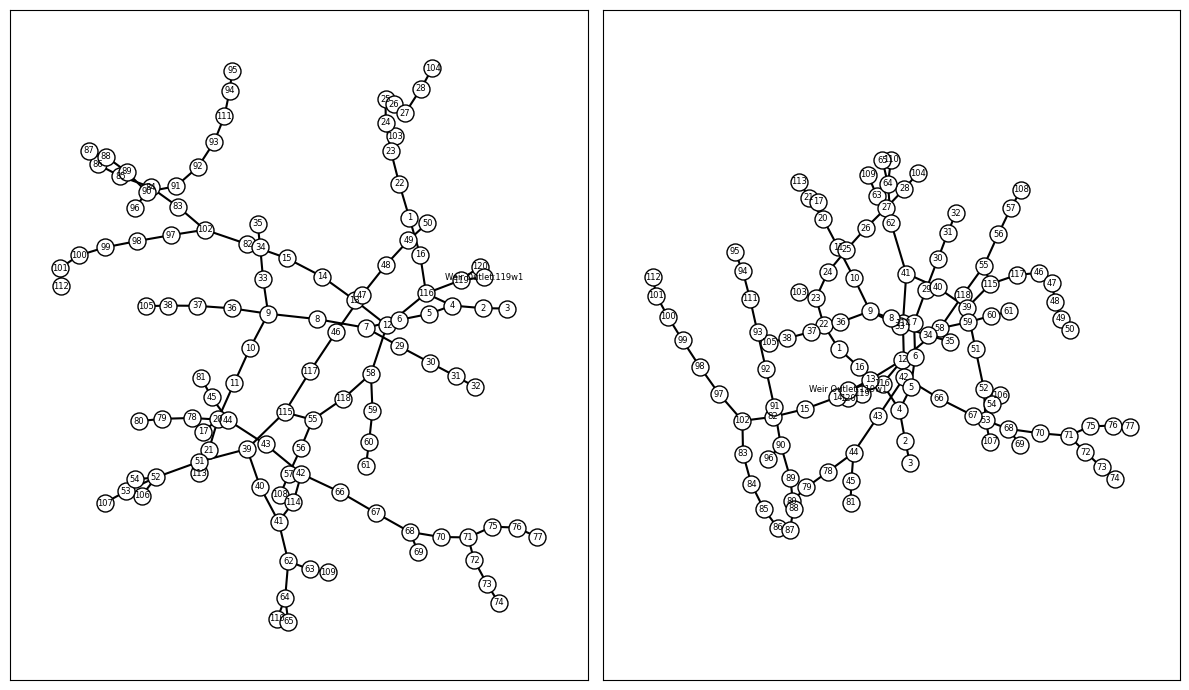

In [66]:
options = {
    "font_size": 6,
    "node_size": 150,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1.5,
}
fig, axes = plt.subplots(1, 2, sharey=True, layout="tight", figsize=(12, 7))
for i, label in enumerate(res.quantities):
    network = QuantityNetwork(res, label) 
    nx.draw_networkx(network.graph, ax=axes[i], **options)

plt.show()